<a href="https://colab.research.google.com/github/ronaknavadiya/pytorch-projects-practice-/blob/Feature%2Foptimization/Hyperparameter_Optuna_Multi_layer_perceptron_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ronaknavadiya
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.41GB/s]

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
!pip install optuna

In [3]:
#  set random seeds for reproducebility
torch.manual_seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:



df = pd.read_csv("/content/fashionmnist/fashion-mnist_train.csv")

# # Convert to small dataset due to CPU utilization
# df = df.sample(n=6000)
df.head()




,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

# Visualise data

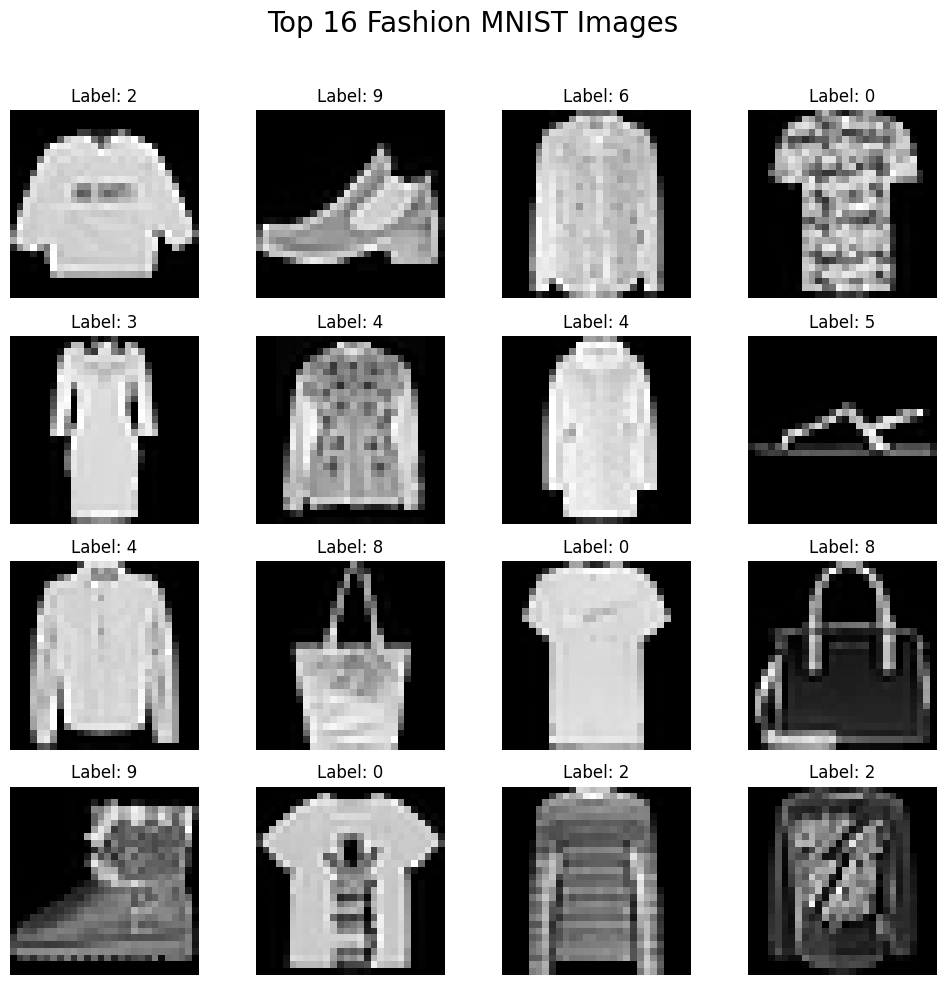

In [7]:
#  create 4 x 4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Top 16 Fashion MNIST Images", fontsize=20)

# plot the first 16 images from df
for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [8]:
#  train test split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#  Scale the features  (max_pixel = 255)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
#  create custom dataset

class CustomDataset(Dataset):

  def __init__(self,features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    #  transformation


    return self.features[idx], self.labels[idx]


In [11]:
#  create train_dataset and test_dataset object

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

print(len(train_dataset))
print(len(test_dataset))

48000
12000


In [12]:
# train and test data loader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Hyperparameter using optuna

In [21]:
#  create NN for hyperparameter objective

class Hyperpameter_NN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(
        *layers,
        # nn.Softmax(dim=1)
    )

  def forward(self, dataset):
    return self.model(dataset)

In [22]:
# Objective function

def objective(trial):

  # extract next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step = 8)
  # learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = Hyperpameter_NN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
  model.to(device)

  # params init
  LR = 0.1
  EPOCHS = 100

  # optimizer & loss dunction  select

  criterian = nn.CrossEntropyLoss() # loss function
  optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay= 1e-4)   # optimizer

  # training loop

  for epoch in range(EPOCHS):
    total_epoch_loss = 0
    for features,labels in train_dataloader:

      features = features.to(device)
      labels = labels.to(device)

      # forward pass
      X_train_pred = model(features)

      # calculate loss
      loss = criterian(X_train_pred, labels)

      # back propogation
      optimizer.zero_grad()
      loss.backward()

      # update weights
      optimizer.step()

  # evalution

  total = 0
  correct = 0

  with torch.no_grad():
    for features,labels in test_dataloader:

      features = features.to(device)
      labels = labels.to(device)

      # forward pass
      X_test_pred = model(features)

      # get predictions
      predictions = torch.argmax(X_test_pred, dim=1)

      total = total + labels.size(0)
      correct = correct + (predictions == labels).sum().item()

      # loss
      loss = criterian(X_test_pred, labels)

    total_accuracy = correct/total * 100

  # return accuracy
  return total_accuracy

In [23]:
import optuna

study = optuna.create_study(direction="maximize")


[I 2025-08-15 15:50:11,654] A new study created in memory with name: no-name-9cb67d6b-5c07-470b-86eb-caecd367bf13


In [ ]:
study.optimize(objective, n_trials=10)

[I 2025-08-15 15:55:33,017] Trial 0 finished with value: 81.28333333333333 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 32}. Best is trial 0 with value: 81.28333333333333.


In [ ]:
study.best_value

In [ ]:
study.best_params